In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset dan data loader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size,scale = (0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [5]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [7]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Arsitektur dan config

In [8]:
# MAnual 
# nn.Conv2d(3,8,3,1,1),
# nn.ReLU(),
# nn.MaxPool2d(2,2)

In [10]:
from jcopdl.layers import conv_block, linear_block

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3,8),
            conv_block(8,16),
            conv_block(16,32),
            conv_block(32,64),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(1024,256, dropout=0.1),
            linear_block(256,2, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [20]:
config = set_config({
    "batch_size":bs,
    "crop_size":crop_size
})

# Training preparation -> MCOC

In [21]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

In [22]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.6914 | Test_cost  = 0.6817 | Train_score = 0.4940 | Test_score = 0.5750 |




Epoch     2
Train_cost  = 0.6681 | Test_cost  = 0.6251 | Train_score = 0.7060 | Test_score = 0.6825 |




Epoch     3
Train_cost  = 0.5855 | Test_cost  = 0.5027 | Train_score = 0.7230 | Test_score = 0.7525 |




Epoch     4
Train_cost  = 0.5077 | Test_cost  = 0.5570 | Train_score = 0.7670 | Test_score = 0.7225 |
==> EarlyStop patience =  1 | Best test_score: 0.7525




Epoch     5
Train_cost  = 0.4741 | Test_cost  = 0.4350 | Train_score = 0.7620 | Test_score = 0.8075 |




Epoch     6
Train_cost  = 0.4755 | Test_cost  = 0.4640 | Train_score = 0.7700 | Test_score = 0.7725 |
==> EarlyStop patience =  1 | Best test_score: 0.8075




Epoch     7
Train_cost  = 0.4476 | Test_cost  = 0.4077 | Train_score = 0.7830 | Test_score = 0.7950 |
==> EarlyStop patience =  2 | Best test_score: 0.8075




Epoch     8
Train_cost  = 0.4345 | Test_cost  = 0.3962 | Train_score = 0.8030 | Test_score = 0.8300 |




Epoch     9
Train_cost  = 0.4345 | Test_cost  = 0.4482 | Train_score = 0.7960 | Test_score = 0.7875 |
==> EarlyStop patience =  1 | Best test_score: 0.8300




Epoch    10
Train_cost  = 0.4637 | Test_cost  = 0.4889 | Train_score = 0.7900 | Test_score = 0.7350 |
==> EarlyStop patience =  2 | Best test_score: 0.8300




Epoch    11
Train_cost  = 0.4303 | Test_cost  = 0.4303 | Train_score = 0.8160 | Test_score = 0.8050 |
==> EarlyStop patience =  3 | Best test_score: 0.8300




Epoch    12
Train_cost  = 0.4163 | Test_cost  = 0.4093 | Train_score = 0.8180 | Test_score = 0.8150 |
==> EarlyStop patience =  4 | Best test_score: 0.8300




Epoch    13
Train_cost  = 0.4062 | Test_cost  = 0.3622 | Train_score = 0.8160 | Test_score = 0.8450 |




Epoch    14
Train_cost  = 0.4003 | Test_cost  = 0.3502 | Train_score = 0.8120 | Test_score = 0.8625 |




Epoch    15
Train_cost  = 0.3948 | Test_cost  = 0.3537 | Train_score = 0.8150 | Test_score = 0.8650 |




Epoch    16
Train_cost  = 0.3856 | Test_cost  = 0.3514 | Train_score = 0.8290 | Test_score = 0.8625 |
==> EarlyStop patience =  1 | Best test_score: 0.8650




Epoch    17
Train_cost  = 0.3853 | Test_cost  = 0.3451 | Train_score = 0.8330 | Test_score = 0.8550 |
==> EarlyStop patience =  2 | Best test_score: 0.8650




Epoch    18
Train_cost  = 0.3987 | Test_cost  = 0.3512 | Train_score = 0.8170 | Test_score = 0.8525 |
==> EarlyStop patience =  3 | Best test_score: 0.8650




Epoch    19
Train_cost  = 0.3877 | Test_cost  = 0.3463 | Train_score = 0.8260 | Test_score = 0.8475 |
==> EarlyStop patience =  4 | Best test_score: 0.8650




Epoch    20
Train_cost  = 0.3548 | Test_cost  = 0.3372 | Train_score = 0.8480 | Test_score = 0.8575 |


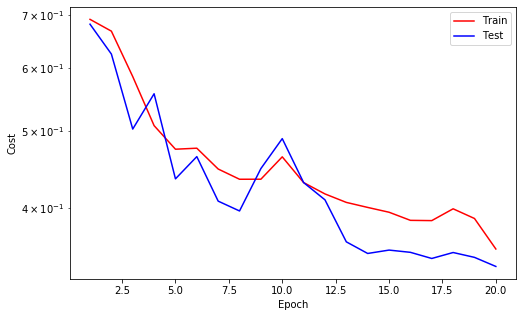

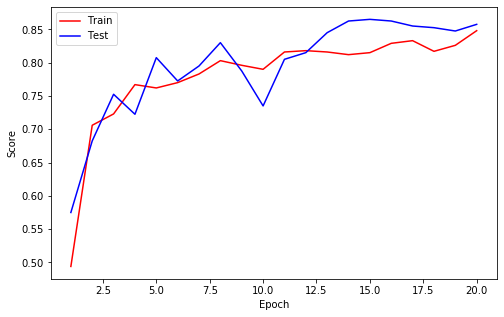

==> EarlyStop patience =  5 | Best test_score: 0.8650
==> Execute Early Stopping at epoch: 20 | Best test_score: 0.8650
==> Best model is saved at model


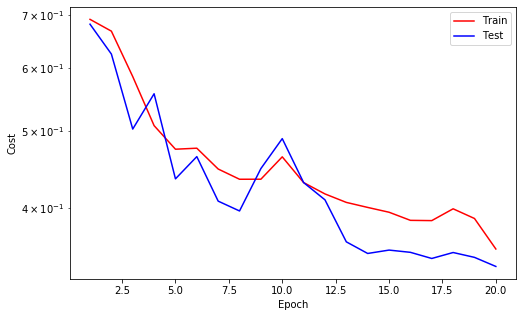

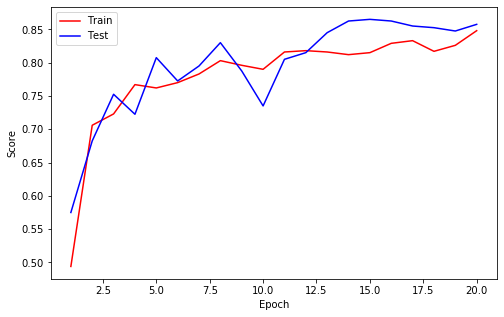

In [23]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict 

In [24]:
feature, target = next(iter(testloader))
feature, target =  feature.to(device), target.to(device)

In [25]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 1])

# Visualization

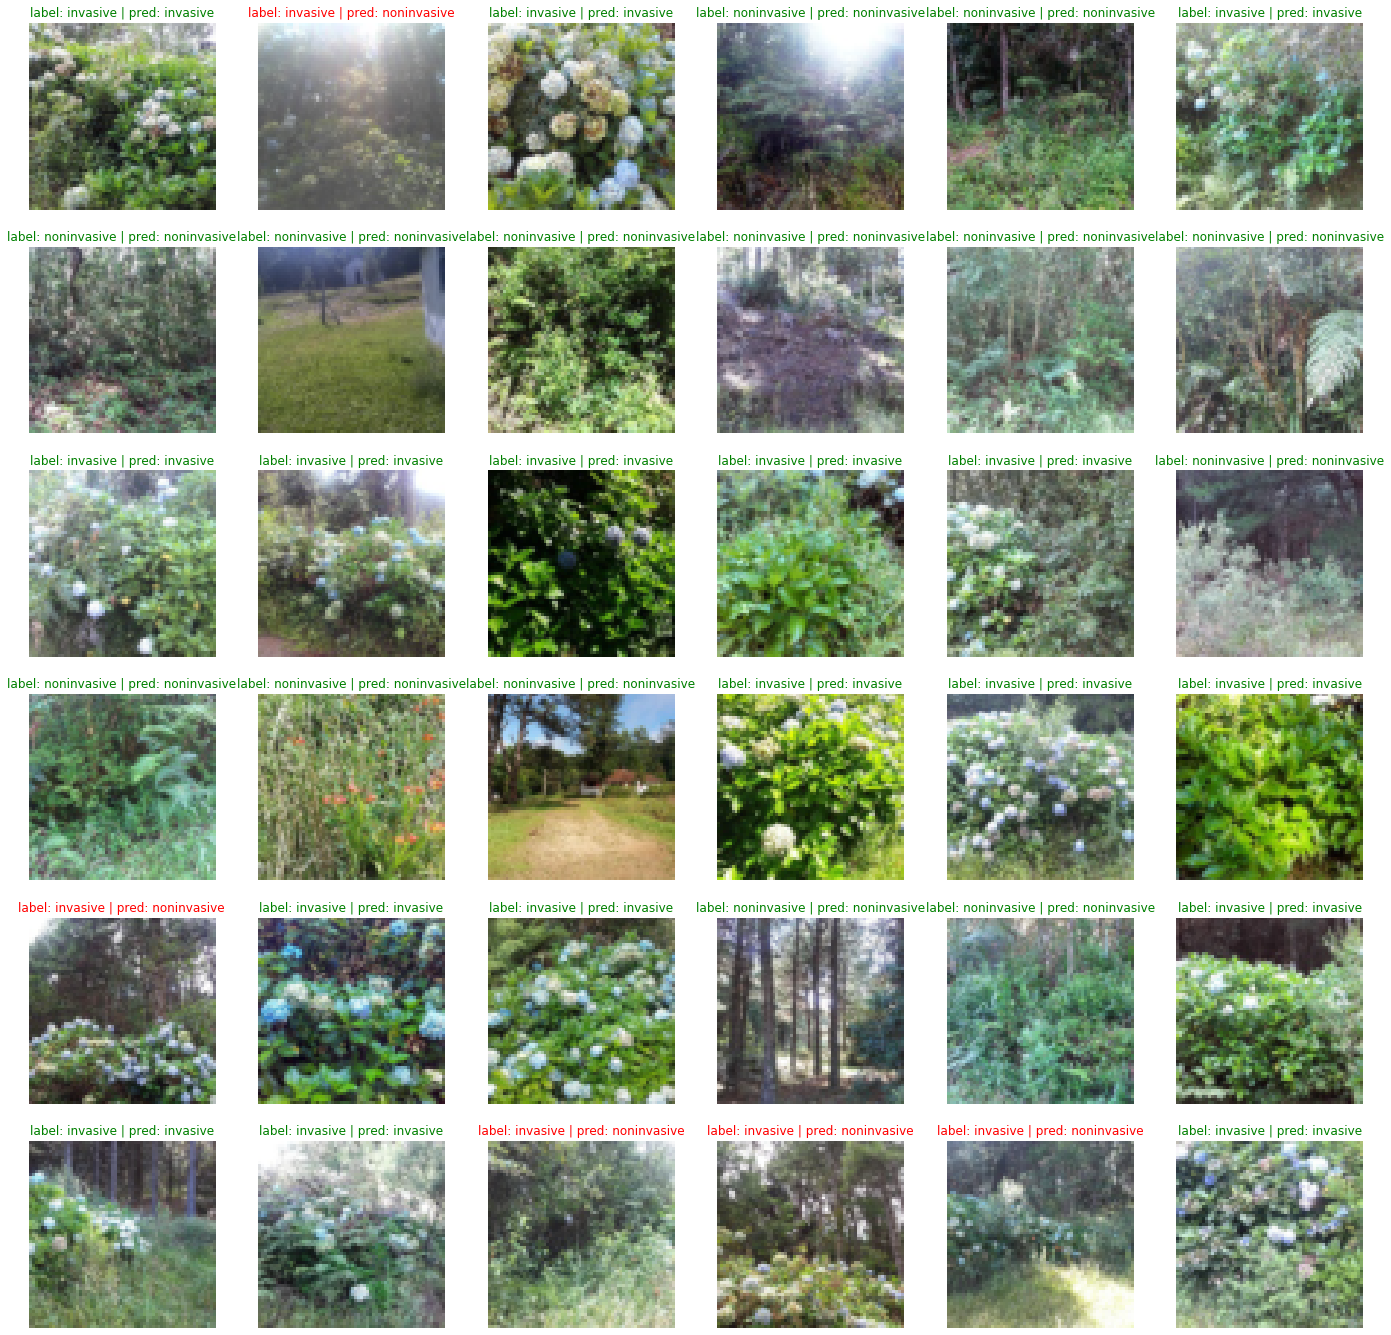

In [31]:
fig, axes = plt.subplots(6,6, figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu(), cmap="gray")
    font = {"Color": "r"} if label != pred else {"color":"g"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"label: {label} | pred: {pred}", fontdict=font);
    ax.axis("off")